In [13]:
import numpy as np
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Initialize empty lists to store images and labels
X = []
Y = []

In [14]:
# Directories for each face direction (bottom, top, left, right)
directions = ['bottom', 'left', 'right', 'top']
image_directory = 'Dataset/Object'  # Replace with the actual path

# Loop through the directories and load images
for label, direction in enumerate(directions):
    for img_path in glob(f'{image_directory}/{direction}/*'):
        img = Image.open(img_path).resize((64, 64))  # Resize to 64x64 (as per your requirement)
        img_array = np.array(img)  # Convert image to numpy array
        X.append(img_array)  # Add image to X
        Y.append(label) 

In [15]:
# Convert lists to numpy arrays
X = np.array(X) / 255.0  # Normalize pixel values to [0, 1]
Y = np.array(Y)

# One-hot encode the labels 
Y = to_categorical(Y, num_classes=4)

In [16]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))  # Input layer
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max Pooling
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten the output to feed into fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))

# Output layer: 4 units for 4 directions, softmax for multi-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

g:\GitHub\Child_Support\adhd\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'face_direction_model.keras',  # Save the model as a .h5 file
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,  # Training data
    validation_data=(x_test, y_test),  # Validation data
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=[checkpoint]  # Use the checkpoint callback
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2009 - loss: 4.6401
Epoch 1: val_loss improved from inf to 1.35973, saving model to face_direction_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.2095 - loss: 4.5836 - val_accuracy: 0.4275 - val_loss: 1.3597
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4329 - loss: 1.7155
Epoch 2: val_loss did not improve from 1.35973
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4375 - loss: 1.6973 - val_accuracy: 0.2443 - val_loss: 1.3807
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4961 - loss: 1.3669
Epoch 3: val_loss did not improve from 1.35973
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.4982 - loss: 1.3540 - val_accuracy: 0.2748 - val_loss: 1.5509
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5791 - loss: 1.2522
Epoch 4: val_loss did not improve from 1.35973
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5827 - loss: 1.2451 - val_accuracy

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

5/5 - 0s - 25ms/step - accuracy: 0.2748 - loss: 3.2298
Test accuracy: 0.2748091518878937


In [20]:
# Save the final trained model
model.save('face_direction_model_final.h5')

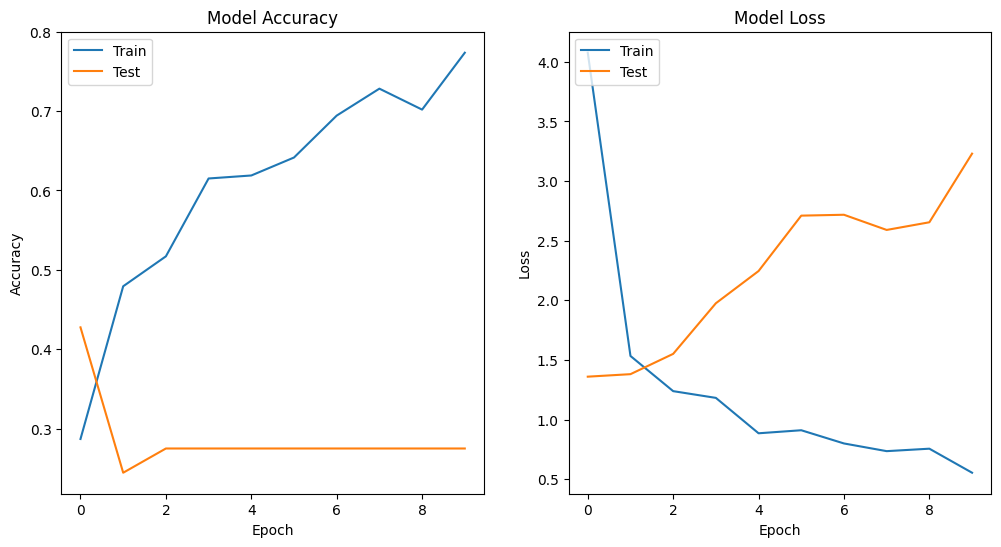

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


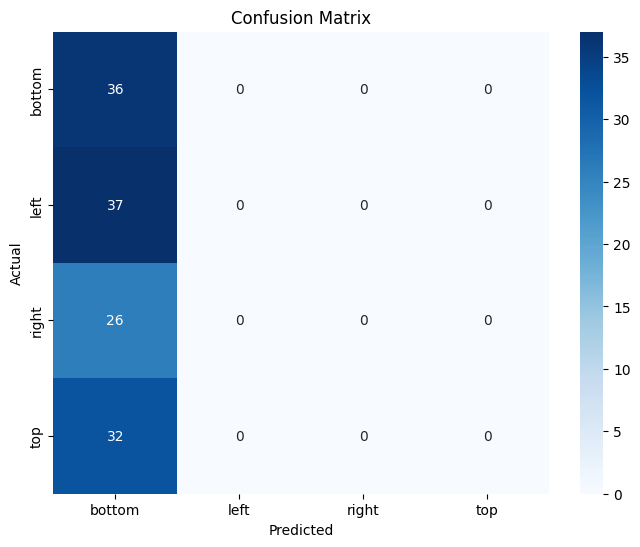

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Get true classes
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=directions, yticklabels=directions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


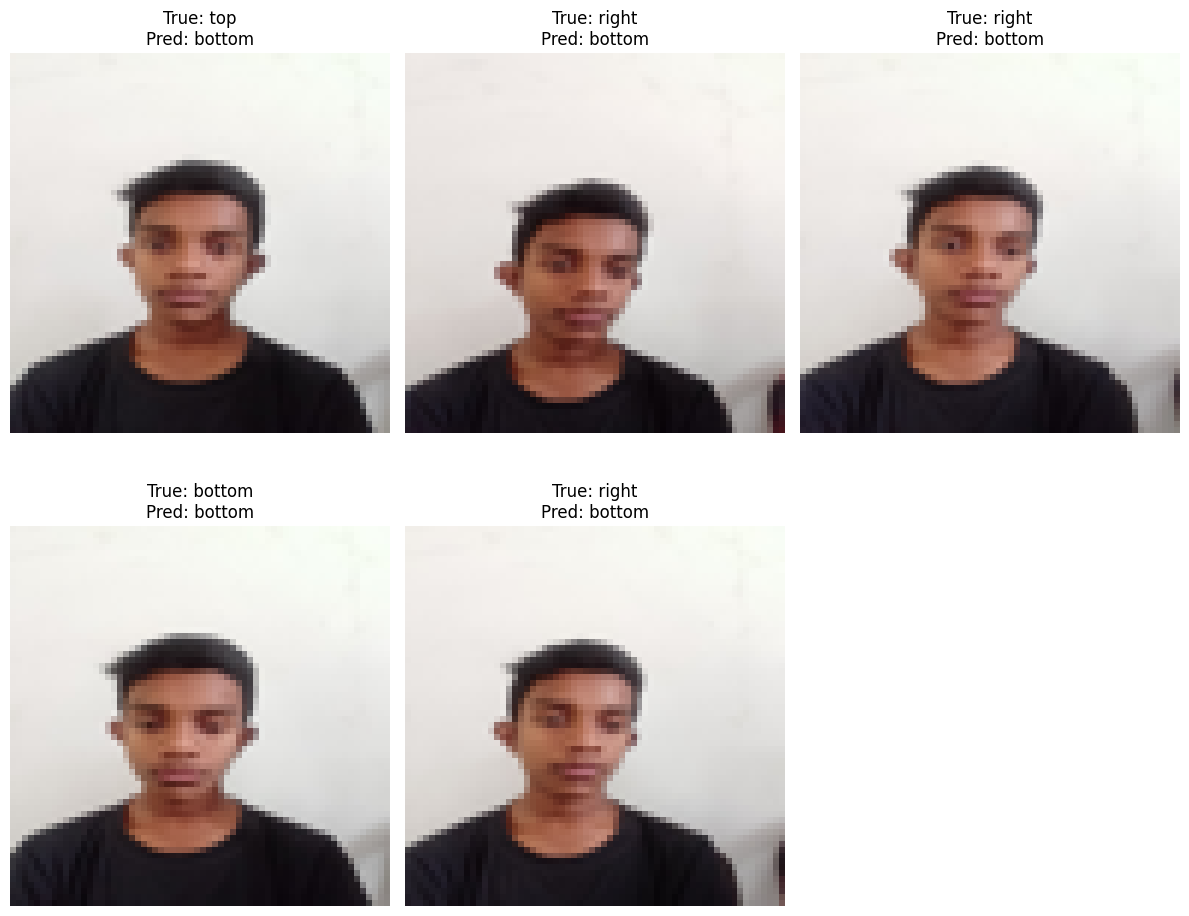

In [23]:
import random

# Select random indices from the test set
random_indices = random.sample(range(len(x_test)), 5)

# Display predictions for 5 random images
plt.figure(figsize=(12, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    
    # Get image and true label
    image = x_test[idx]
    true_label = np.argmax(y_test[idx])
    true_label_name = directions[true_label]
    
    # Get predicted label
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_label = np.argmax(pred)
    pred_label_name = directions[pred_label]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()


C:\conda_tmp\ipykernel_15228\495035213.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(y_train, axis=1), palette='Set2')


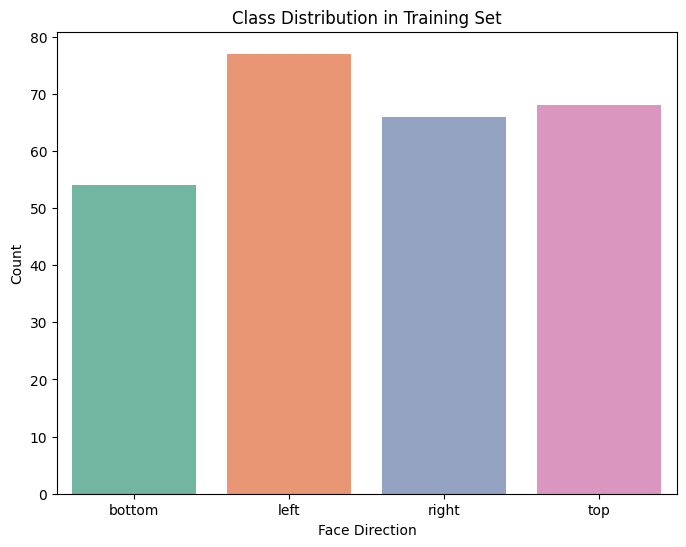

In [24]:
import seaborn as sns

# Plot the class distribution in the training set
plt.figure(figsize=(8, 6))
sns.countplot(x=np.argmax(y_train, axis=1), palette='Set2')
plt.title('Class Distribution in Training Set')
plt.xlabel('Face Direction')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(4), labels=directions)
plt.show()
